# 1.0 Dependencies

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
from scipy.stats import chi2_contingency
plt.style.use('ggplot')

# 2.0 Dataset Loading

Load transaction (Transactions_Cleaned.csv) and customer demographic (Cleaned_Customer_Demographic_Dataset.csv) datasets.

In [2]:
def load_and_display_datasets():
    trans = pd.read_csv('Transactions_Cleaned.csv')
    cust = pd.read_csv('Cleaned_Customer_Demographic_Dataset.csv') 
    return trans, cust

In [3]:
def display_Transaction_dataset_info(trans):
    print("Transaction Dataset:")
    display_dataset_info(trans, "Transaction")

In [4]:
def display_Customer_Demographics_dataset_info(cust):
    print("\nCustomer Demographics Dataset:")
    display_dataset_info(cust, "Customer Demographics")

In [5]:
def display_dataset_info(dataset, dataset_name):
    print(f"\nTotal records (rows) in the {dataset_name} Dataset: {len(dataset)}")
    print(f"Total features (columns) in the {dataset_name} Dataset: {dataset.shape[1]}")
    print(dataset)
    display(dataset.head(5))

# 3.0 Merging Datasets

Merge the two datasets using the merge function.

In [6]:
def merge(trans, cust):
    merged_dataset = pd.merge(trans, cust, left_on='customer_id', right_on='customer_id', how='inner')
    return merged_dataset

In [7]:
def display_datasets(trans, cust):
    print("\nMerge Datasets")
    display_dataset_info(merged_dataset, "Merged")
    return merged_dataset

In [8]:
def convert_to_datetime(df):
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    return df

In [9]:
def calculate_rfm_table(merged_dataset):
    merged_dataset = convert_to_datetime(merged_dataset)
    max_trans_date = max(merged_dataset['transaction_date']).date()
    comparison_date = datetime.strptime(str(max_trans_date), "%Y-%m-%d")
    rfm_table = merged_dataset.groupby(['customer_id']).agg({
        'transaction_date': lambda date: (comparison_date - date.max()).days,
        'product_id': lambda prod_id: len(prod_id),
        'Profit': lambda p: sum(p)
    })
    rfm_table.rename(columns={'transaction_date': 'recency',
                              'product_id': 'frequency',
                              'Profit': 'monetary'}, inplace=True)
    return rfm_table

In [10]:
def calculate_rfm_score(rfm_table):
    rfm_table['r_quartile'] = pd.qcut(rfm_table['recency'], 4, ['4', '3', '2', '1'])
    rfm_table['f_quartile'] = pd.qcut(rfm_table['frequency'], 4, ['1', '2', '3', '4'])
    rfm_table['m_quartile'] = pd.qcut(rfm_table['monetary'], 4, ['1', '2', '3', '4'])
    rfm_table['rfm_score'] = 100 * rfm_table['r_quartile'].astype(int) + \
                             10 * rfm_table['f_quartile'].astype(int) + \
                             rfm_table['m_quartile'].astype(int)
    return rfm_table

In [11]:
def assign_customer_title(rfm_table):
    rfm_table['customer_title'] = pd.qcut(rfm_table['rfm_score'], 4, ['Bronze', 'Silver', 'Gold', 'Platinum'])
    return rfm_table

In [12]:
# Function to perform RFM analysis
def perform(merged_dataset):
    rfm_table = calculate_rfm_table(merged_dataset)
    rfm_table = calculate_rfm_score(rfm_table)
    rfm_table = assign_customer_title(rfm_table)
    
    # Call the function for Interactive RFM Scatter Plot
    interactive_rfm_scatter(rfm_table)
    return rfm_table

In [13]:
def display_rfm_analysis(merged_dataset):
    print("\nPerform RFM Analysis")
    display_dataset_info(rfm_table, "RFM Analysis")
    return rfm_table

In [14]:
def merge_and_display_rfm_with_datasets(merged_dataset, rfm_table):
    cust_trans_rfm = pd.merge(merged_dataset, rfm_table, left_on='customer_id', right_on='customer_id', how='inner')
    print("\nMerge RFM Table with Original Datasets")
    display_dataset_info(cust_trans_rfm, "Final")
    return cust_trans_rfm

In [15]:
def cust_score_title_lkup(cols):    
    rfm_score = cols[0] 
    if rfm_score >= 444:
        return 'Top Tier Customer'
    elif rfm_score >=433 and rfm_score < 444:
        return 'Engaged Customer'
    elif rfm_score >=421 and rfm_score < 433:
        return 'Emerging Loyal Customer'
    elif rfm_score >=344 and rfm_score < 421:
        return 'Recent Customer'
    elif rfm_score >=323 and rfm_score < 344:
        return 'Prospective Customer'
    elif rfm_score >=311 and rfm_score < 323:
        return 'Delayed Adopter'
    elif rfm_score >=224 and rfm_score < 311:
        return 'Drifting Customer'
    elif rfm_score >=212 and rfm_score < 224:
        return 'High Risk Customer'
    elif rfm_score >=124 and rfm_score < 212:
        return 'Slipping Customer'
    elif rfm_score >=112 and rfm_score < 124:
        return 'Inactive Customer'
    else :
        return 'Churned Customer'

In [16]:
def create_age_group_feature(cust_trans_rfm):
    cust_trans_rfm['Age_Group'] = cust_trans_rfm['Age'].apply(lambda x: (math.floor(x / 10) + 1) * 10)

In [17]:
# Function to create Detail Customer title based on RFM Score
def create_detail_cust_title(cust_trans_rfm):
    cust_trans_rfm['detail_cust_title']=cust_trans_rfm[['rfm_score']].apply(cust_score_title_lkup, axis=1)

In [18]:
def get_rank(cols):  
    title = cols[0] 
    if title=='Top Tier Customer':
        return 1
    elif title=='Engaged Customer':
        return 2
    elif title == 'Emerging Loyal Customer':
        return 3
    elif title == 'Recent Customer':
        return 4
    elif title=='Prospective Customer':
        return 5
    elif title == 'Delayed Adopter':
        return 6
    elif title == 'Drifting Customer':
        return 7
    elif title=='High Risk Customer':
        return 8
    elif title == 'Slipping Customer':
        return 9
    elif title == 'Inactive Customer':
        return 10
    else :
        return 11

In [19]:
def create_rank_feature(cust_trans_rfm):
    cust_trans_rfm['rank']=cust_trans_rfm[['customer_title']].apply(get_rank, axis=1)

In [20]:
def create_and_display_additional_features(cust_trans_rfm):
    print("\nCreate Additional Features")
    create_age_group_feature(cust_trans_rfm)
    create_detail_cust_title(cust_trans_rfm)
    create_rank_feature(cust_trans_rfm)

In [21]:
def visualize_product_analysis(merged_dataset):
    print("Perform Product Analysis")
    display_dataset_info(product_analysis, "Product Analysis")

In [22]:
    # Function for Interactive RFM Scatter Plot
    def interactive_rfm_scatter(rfm_table):
        fig = px.scatter(rfm_table, x='recency', y='frequency', color='monetary', size='rfm_score',
                         hover_data=['customer_title'], title='RFM Analysis',
                         labels={'recency': 'Recency', 'frequency': 'Frequency', 'monetary': 'Monetary'})
        fig.show()

In [23]:
def display_final_with_additional_features(cust_trans_rfm):
    print("\nSDisplay Information about the Dataset with Additional Features")
    display_dataset_info(cust_trans_rfm, "Final with Additional Features")

In [24]:
def export_and_display_csv(cust_trans_rfm):
    print("\nExport the Final Dataset to CSV")
    cust_trans_rfm.to_csv('Customer_Trans_RFM__Dataset_Analysis.csv', index=False)
    print(f"Total records in final dataset: {cust_trans_rfm.shape[0]}")

In [25]:
def perform_product_analysis(merged_dataset):
    product_analysis = merged_dataset.groupby('product_id').agg({
        'Profit': 'sum',
        'list_price': 'mean',
    })
    print("Product Analysis Summary:")
    print(product_analysis.describe())
    return product_analysis

In [26]:
trans, cust = load_and_display_datasets()

In [27]:
merged_dataset = merge(trans, cust)

In [28]:
merged_dataset.to_csv('Merged_dataset.csv', index=False)

In [29]:
rfm_table = perform(merged_dataset)

In [30]:
interactive_rfm_scatter(rfm_table)

In [31]:
cust_trans_rfm = merge_and_display_rfm_with_datasets(merged_dataset, rfm_table)


Merge RFM Table with Original Datasets

Total records (rows) in the Final Dataset: 19362
Total features (columns) in the Final Dataset: 34
       transaction_id  product_id  customer_id transaction_date  online_order  \
0                   1           2         2950       2017-02-25           0.0   
1               11065           1         2950       2017-10-16           0.0   
2               18923          62         2950       2017-04-26           0.0   
3                   2           3         3120       2017-05-21           1.0   
4                6862           4         3120       2017-10-05           0.0   
...               ...         ...          ...              ...           ...   
19357           18735          45         3168       2017-02-21           1.0   
19358           18789          83         3168       2017-04-11           0.0   
19359           19113           3         3168       2017-06-03           0.0   
19360           19912           3         3168    

transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1           11065           1         2950       2017-10-16           0.0   
2           18923          62         2950       2017-04-26           0.0   
3               2           3         3120       2017-05-21           1.0   
4            6862           4         3120       2017-10-05           0.0   

  order_status           brand product_line product_class product_size  ...  \
0     Approved           Solex     Standard        medium       medium  ...   
1     Approved  Giant Bicycles     Standard        medium       medium  ...   
2     Approved           Solex     Standard        medium       medium  ...   
3     Approved   Trek Bicycles     Standard        medium        large  ...   
4     Approved  Giant Bicycles     Standard          high       medium  ...   

   tenure  Age  recency  frequency monetary r_quartile f_quartile  m_quartile  \
0    10.0   69       75          3   645.99          2          1           1   
1    10.0   69       75          3   645.99          2          1           1   
2    10.0   69       75          3   645.99          2          1           1   
3    10.0   45       20          7  4179.11          3          3           4   
4    10.0   45       20          7  4179.11          3          3           4   

  rfm_score customer_title  
0       211         Bronze  
1       211         Bronze  
2       211         Bronze  
3       334           Gold  
4       334           Gold  

[5 rows x 34 columns]

In [32]:
display_Transaction_dataset_info(trans)

Transaction Dataset:

Total records (rows) in the Transaction Dataset: 19803
Total features (columns) in the Transaction Dataset: 14
       transaction_id  product_id  customer_id transaction_date  online_order  \
0                   1           2         2950       2017-02-25           0.0   
1                   2           3         3120       2017-05-21           1.0   
2                   3          37          402       2017-10-16           0.0   
3                   4          88         3135       2017-08-31           0.0   
4                   5          78          787       2017-10-01           1.0   
...               ...         ...          ...              ...           ...   
19798           19996          51         1018       2017-06-24           1.0   
19799           19997          41          127       2017-11-09           1.0   
19800           19998          87         2284       2017-04-14           1.0   
19801           19999           6         2764       2017

transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date   Profit  
0       71.49          53.62                  41245.0    17.87  
1     2091.47         388.92                  41701.0  1702.55  
2     1793.43         248.82                  36361.0  1544.61  
3     1198.46         381.10                  36145.0   817.36  
4     1765.30         709.48                  42226.0  1055.82

In [33]:
display_Customer_Demographics_dataset_info(cust)


Customer Demographics Dataset:

Total records (rows) in the Customer Demographics Dataset: 3913
Total features (columns) in the Customer Demographics Dataset: 13
      customer_id      first_name  last_name  gender  \
0               1         Laraine  Medendorp  Female   
1               2             Eli    Bockman    Male   
2               3           Arlin     Dearle    Male   
3               4          Talbot        NaN    Male   
4               5  Sheila-kathryn     Calton  Female   
...           ...             ...        ...     ...   
3908         3995           Rusty     Iapico    Male   
3909         3996         Rosalia   Halgarth  Female   
3910         3997          Blanch     Nisuis  Female   
3911         3999       Patrizius        NaN    Male   
3912         4000           Kippy    Oldland    Male   

      past_3_years_bike_related_purchases         DOB               job_title  \
0                                      93  1953-10-12     Executive Secretary   
1 

customer_id      first_name  last_name  gender  \
0            1         Laraine  Medendorp  Female   
1            2             Eli    Bockman    Male   
2            3           Arlin     Dearle    Male   
3            4          Talbot        NaN    Male   
4            5  Sheila-kathryn     Calton  Female   

   past_3_years_bike_related_purchases         DOB               job_title  \
0                                   93  1953-10-12     Executive Secretary   
1                                   81  1980-12-16  Administrative Officer   
2                                   61  1954-01-20      Recruiting Manager   
3                                   33  1961-10-03                 Missing   
4                                   56  1977-05-13           Senior Editor   

  job_industry_category     wealth_segment deceased_indicator owns_car  \
0                Health      Mass Customer                  N      Yes   
1    Financial Services      Mass Customer                  N      Yes   
2              Property      Mass Customer                  N      Yes   
3                    IT      Mass Customer                  N       No   
4               Missing  Affluent Customer                  N      Yes   

   tenure  Age  
0    11.0   70  
1    16.0   43  
2    15.0   70  
3     7.0   62  
4     8.0   46

In [34]:
display_datasets(trans, cust)


Merge Datasets

Total records (rows) in the Merged Dataset: 19362
Total features (columns) in the Merged Dataset: 26
       transaction_id  product_id  customer_id transaction_date  online_order  \
0                   1           2         2950       2017-02-25           0.0   
1               11065           1         2950       2017-10-16           0.0   
2               18923          62         2950       2017-04-26           0.0   
3                   2           3         3120       2017-05-21           1.0   
4                6862           4         3120       2017-10-05           0.0   
...               ...         ...          ...              ...           ...   
19357           18735          45         3168       2017-02-21           1.0   
19358           18789          83         3168       2017-04-11           0.0   
19359           19113           3         3168       2017-06-03           0.0   
19360           19912           3         3168       2017-09-30         

transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1           11065           1         2950       2017-10-16           0.0   
2           18923          62         2950       2017-04-26           0.0   
3               2           3         3120       2017-05-21           1.0   
4            6862           4         3120       2017-10-05           0.0   

  order_status           brand product_line product_class product_size  ...  \
0     Approved           Solex     Standard        medium       medium  ...   
1     Approved  Giant Bicycles     Standard        medium       medium  ...   
2     Approved           Solex     Standard        medium       medium  ...   
3     Approved   Trek Bicycles     Standard        medium        large  ...   
4     Approved  Giant Bicycles     Standard          high       medium  ...   

   gender  past_3_years_bike_related_purchases         DOB  \
0    Male                                   19  1955-01-11   
1    Male                                   19  1955-01-11   
2    Male                                   19  1955-01-11   
3  Female                                   89  1979-02-04   
4  Female                                   89  1979-02-04   

             job_title job_industry_category wealth_segment  \
0  Software Engineer I    Financial Services  Mass Customer   
1  Software Engineer I    Financial Services  Mass Customer   
2  Software Engineer I    Financial Services  Mass Customer   
3  Clinical Specialist                Health  Mass Customer   
4  Clinical Specialist                Health  Mass Customer   

  deceased_indicator  owns_car tenure Age  
0                  N       Yes   10.0  69  
1                  N       Yes   10.0  69  
2                  N       Yes   10.0  69  
3                  N       Yes   10.0  45  
4                  N       Yes   10.0  45  

[5 rows x 26 columns]

transaction_id  product_id  customer_id transaction_date  online_order  \
0                   1           2         2950       2017-02-25           0.0   
1               11065           1         2950       2017-10-16           0.0   
2               18923          62         2950       2017-04-26           0.0   
3                   2           3         3120       2017-05-21           1.0   
4                6862           4         3120       2017-10-05           0.0   
...               ...         ...          ...              ...           ...   
19357           18735          45         3168       2017-02-21           1.0   
19358           18789          83         3168       2017-04-11           0.0   
19359           19113           3         3168       2017-06-03           0.0   
19360           19912           3         3168       2017-09-30           0.0   
19361           18822          30         3464       2017-12-13           1.0   

      order_status           brand product_line product_class product_size  \
0         Approved           Solex     Standard        medium       medium   
1         Approved  Giant Bicycles     Standard        medium       medium   
2         Approved           Solex     Standard        medium       medium   
3         Approved   Trek Bicycles     Standard        medium        large   
4         Approved  Giant Bicycles     Standard          high       medium   
...            ...             ...          ...           ...          ...   
19357     Approved           Solex     Standard        medium       medium   
19358     Approved           Solex      Touring        medium        large   
19359     Approved   Trek Bicycles     Standard        medium        large   
19360     Approved   Trek Bicycles     Standard        medium        large   
19361     Approved           Solex     Standard          high       medium   

       ...  gender  past_3_years_bike_related_purchases         DOB  \
0      ...    Male                                   19  1955-01-11   
1      ...    Male                                   19  1955-01-11   
2      ...    Male                                   19  1955-01-11   
3      ...  Female                                   89  1979-02-04   
4      ...  Female                                   89  1979-02-04   
...    ...     ...                                  ...         ...   
19357  ...    Male                                   89  1976-02-16   
19358  ...    Male                                   89  1976-02-16   
19359  ...    Male                                   89  1976-02-16   
19360  ...    Male                                   89  1976-02-16   
19361  ...  Female                                   38  1982-06-09   

                  job_title job_industry_category     wealth_segment  \
0       Software Engineer I    Financial Services      Mass Customer   
1       Software Engineer I    Financial Services      Mass Customer   
2       Software Engineer I    Financial Services      Mass Customer   
3       Clinical Specialist                Health      Mass Customer   
4       Clinical Specialist                Health      Mass Customer   
...                     ...                   ...                ...   
19357     Assistant Manager                Health  Affluent Customer   
19358     Assistant Manager                Health  Affluent Customer   
19359     Assistant Manager                Health  Affluent Customer   
19360     Assistant Manager                Health  Affluent Customer   
19361  Staff Accountant III    Financial Services      Mass Customer   

      deceased_indicator  owns_car tenure Age  
0                      N       Yes   10.0  69  
1                      N       Yes   10.0  69  
2                      N       Yes   10.0  69  
3                      N       Yes   10.0  45  
4                      N       Yes   10.0  45  
...                  ...       ...    ...  ..  
19357                  N        No   22.0  

In [35]:
display_rfm_analysis(merged_dataset)


Perform RFM Analysis

Total records (rows) in the RFM Analysis Dataset: 3417
Total features (columns) in the RFM Analysis Dataset: 8
             recency  frequency  monetary r_quartile f_quartile m_quartile  \
customer_id                                                                  
1                  7         11   3018.09          4          4          3   
2                128          3   2226.26          1          1          2   
3                102          8   3362.81          1          4          3   
4                195          2    220.57          1          1          1   
5                 16          6   2394.94          4          2          2   
...              ...        ...       ...        ...        ...        ...   
3496             256          4   2045.84          1          1          2   
3497              52          3   1648.32          2          1          1   
3498             127          6   3147.33          1          2          3   
3499    

recency  frequency  monetary r_quartile f_quartile m_quartile  \
customer_id                                                                  
1                  7         11   3018.09          4          4          3   
2                128          3   2226.26          1          1          2   
3                102          8   3362.81          1          4          3   
4                195          2    220.57          1          1          1   
5                 16          6   2394.94          4          2          2   

             rfm_score customer_title  
customer_id                            
1                  443       Platinum  
2                  112         Bronze  
3                  143         Bronze  
4                  111         Bronze  
5                  422       Platinum

recency  frequency  monetary r_quartile f_quartile m_quartile  \
customer_id                                                                  
1                  7         11   3018.09          4          4          3   
2                128          3   2226.26          1          1          2   
3                102          8   3362.81          1          4          3   
4                195          2    220.57          1          1          1   
5                 16          6   2394.94          4          2          2   
...              ...        ...       ...        ...        ...        ...   
3496             256          4   2045.84          1          1          2   
3497              52          3   1648.32          2          1          1   
3498             127          6   3147.33          1          2          3   
3499              51          7   4955.25          2          3          4   
3500             144          6   1785.86          1          2          1   

             rfm_score customer_title  
customer_id                            
1                  443       Platinum  
2                  112         Bronze  
3                  143         Bronze  
4                  111         Bronze  
5                  422       Platinum  
...                ...            ...  
3496               112         Bronze  
3497               211         Bronze  
3498               123         Bronze  
3499               234         Silver  
3500               121         Bronze  

[3417 rows x 8 columns]

In [36]:
# Information about the Dataset with Additional Features
display_final_with_additional_features(cust_trans_rfm)


SDisplay Information about the Dataset with Additional Features

Total records (rows) in the Final with Additional Features Dataset: 19362
Total features (columns) in the Final with Additional Features Dataset: 34
       transaction_id  product_id  customer_id transaction_date  online_order  \
0                   1           2         2950       2017-02-25           0.0   
1               11065           1         2950       2017-10-16           0.0   
2               18923          62         2950       2017-04-26           0.0   
3                   2           3         3120       2017-05-21           1.0   
4                6862           4         3120       2017-10-05           0.0   
...               ...         ...          ...              ...           ...   
19357           18735          45         3168       2017-02-21           1.0   
19358           18789          83         3168       2017-04-11           0.0   
19359           19113           3         3168       201

transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1           11065           1         2950       2017-10-16           0.0   
2           18923          62         2950       2017-04-26           0.0   
3               2           3         3120       2017-05-21           1.0   
4            6862           4         3120       2017-10-05           0.0   

  order_status           brand product_line product_class product_size  ...  \
0     Approved           Solex     Standard        medium       medium  ...   
1     Approved  Giant Bicycles     Standard        medium       medium  ...   
2     Approved           Solex     Standard        medium       medium  ...   
3     Approved   Trek Bicycles     Standard        medium        large  ...   
4     Approved  Giant Bicycles     Standard          high       medium  ...   

   tenure  Age  recency  frequency monetary r_quartile f_quartile  m_quartile  \
0    10.0   69       75          3   645.99          2          1           1   
1    10.0   69       75          3   645.99          2          1           1   
2    10.0   69       75          3   645.99          2          1           1   
3    10.0   45       20          7  4179.11          3          3           4   
4    10.0   45       20          7  4179.11          3          3           4   

  rfm_score customer_title  
0       211         Bronze  
1       211         Bronze  
2       211         Bronze  
3       334           Gold  
4       334           Gold  

[5 rows x 34 columns]

In [37]:
export_and_display_csv(cust_trans_rfm)


Export the Final Dataset to CSV
Total records in final dataset: 19362


In [38]:
create_and_display_additional_features(cust_trans_rfm)


Create Additional Features


In [39]:
new_cust = pd.read_csv('Cleaned_New_Customer_List_Dataset.csv')

In [40]:
filtered_new_cust = new_cust[~(new_cust['job_industry_category'] == 'Missing')]
job_industry_percentages = (filtered_new_cust['job_industry_category'].value_counts() / len(filtered_new_cust)) * 100

In [41]:
filtered_cust_trans_rfm = cust_trans_rfm[~(cust_trans_rfm['job_industry_category'] == 'Missing')]
job_industry_percentages = (filtered_cust_trans_rfm['job_industry_category'].value_counts() / len(filtered_cust_trans_rfm)) * 100

In [42]:
cust_addr_info = pd.read_csv('Cleaned_Customer_Address_Dataset.csv')
cust_trans_addr = pd.merge(cust_trans_rfm, cust_addr_info, on='customer_id', how='inner')
print(f"RFM table Records count: {cust_trans_rfm.shape[0]}\nAddress Table Records count: {cust_addr_info.shape[0]}")

RFM table Records count: 19362
Address Table Records count: 3999


In [43]:
wealth_age_seg_new = new_cust.groupby(['wealth_segment', 'Age Group']).size().reset_index()
wealth_age_seg_new.rename(columns={0: 'Number of Customers'}, inplace=True)
total_count_by_wealth_segment = wealth_age_seg_new.groupby('wealth_segment')['Number of Customers'].transform('sum')
wealth_age_seg_new['Percentage'] = (wealth_age_seg_new['Number of Customers'] / total_count_by_wealth_segment) * 100

In [44]:
wealth_age_seg_old = cust_trans_rfm.groupby(['wealth_segment', 'Age_Group']).size().reset_index()
wealth_age_seg_old.rename(columns={0: 'Number of Customers'}, inplace=True)
total_count_by_wealth_old_segment = wealth_age_seg_old.groupby('wealth_segment')['Number of Customers'].transform('sum')
wealth_age_seg_old['old_percentage'] = (wealth_age_seg_old['Number of Customers'] / total_count_by_wealth_old_segment) * 100

In [45]:
cust_per_title = cust_trans_addr[['detail_cust_title', 'customer_id', 'rank']].drop_duplicates().groupby(
    ['detail_cust_title', 'rank']).size().reset_index(name='Number of Customers').sort_values('rank')
cust_per_title.columns = ['Customer Title', 'Rank', 'Number of Customers']
print(cust_per_title)

             Customer Title  Rank  Number of Customers
0          Churned Customer    11                  291
1           Delayed Adopter    11                  332
2         Drifting Customer    11                  333
3   Emerging Loyal Customer    11                  343
4          Engaged Customer    11                  181
5        High Risk Customer    11                  371
6         Inactive Customer    11                  389
7      Prospective Customer    11                  339
8           Recent Customer    11                  357
9         Slipping Customer    11                  313
10        Top Tier Customer    11                  164


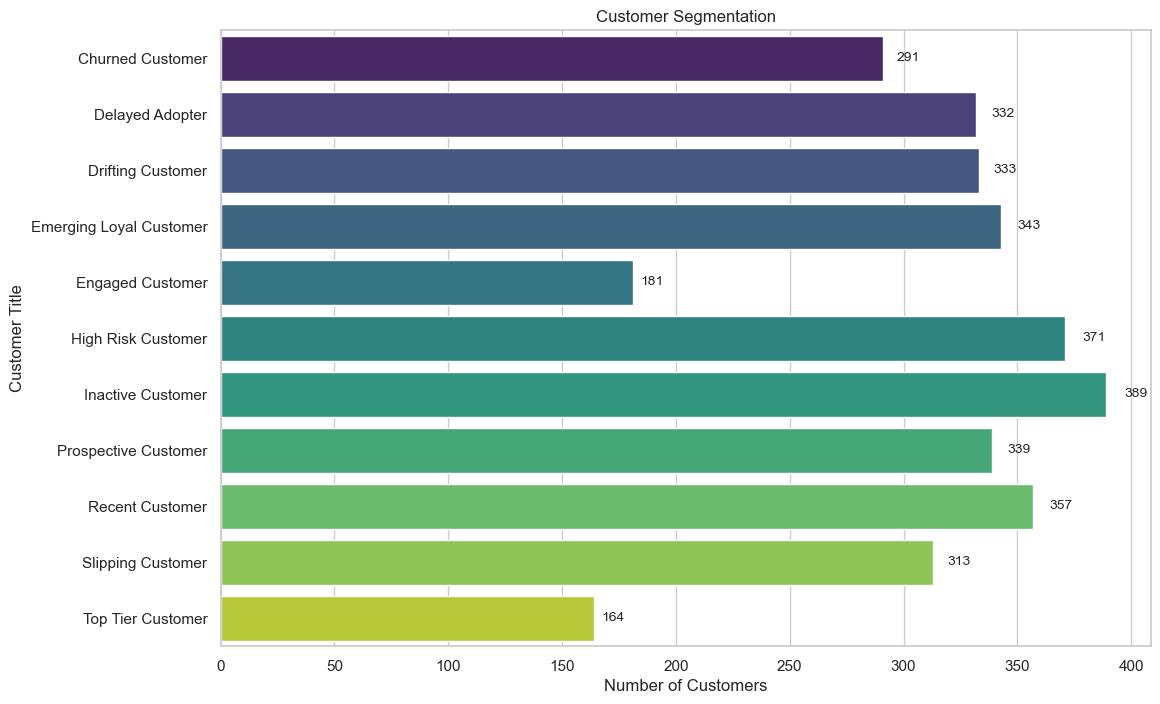

In [80]:
#bar plot for customer segmentation
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Number of Customers', y='Customer Title', data=cust_per_title, palette='viridis')

for p in ax.patches:
    height = p.get_height()
    width = p.get_width()

    if not pd.isna(width):
        ax.text(width * 1.02, p.get_y() + height / 2, f'{int(width)}', ha='left', va='center', fontsize=10)

plt.xlabel('Number of Customers')
plt.ylabel('Customer Title')
plt.title('Customer Segmentation')

plt.show()


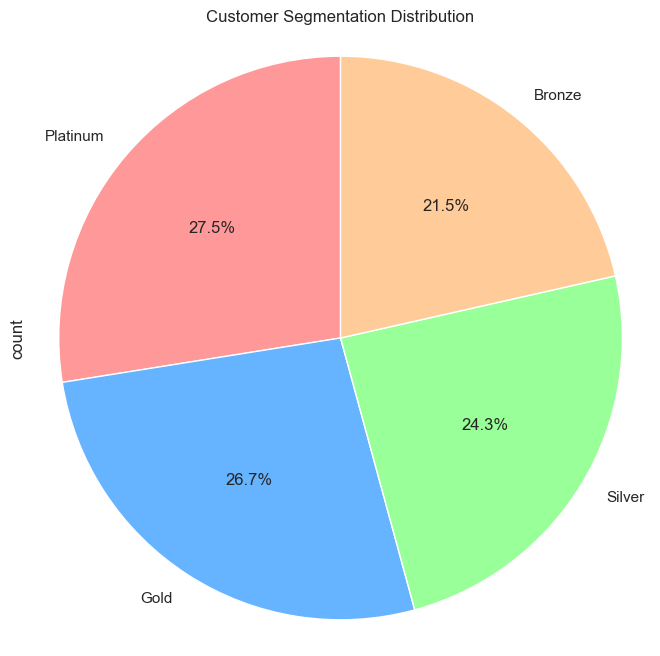

In [47]:
plt.figure(figsize=(8, 8))
cust_trans_rfm['customer_title'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Customer Segmentation Distribution')
plt.axis('equal')
plt.show()

In [82]:
fig = px.scatter(cust_trans_rfm, x='recency', y='frequency', color='customer_title', size='monetary',
                 hover_data=['customer_id'], title='RFM Analysis', labels={'recency': 'Recency', 'frequency': 'Frequency', 'monetary': 'Monetary'})
fig.show()

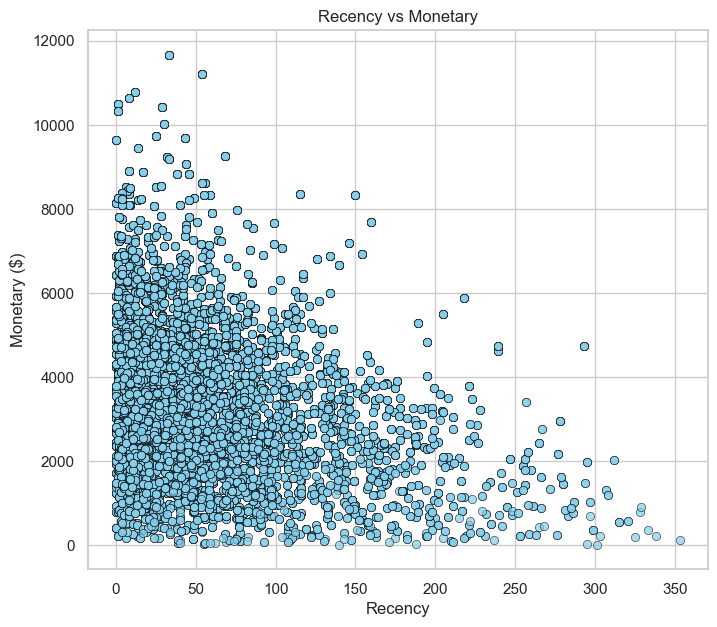

In [49]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 7))
sns.scatterplot(data=cust_trans_rfm, x='recency', y='monetary', color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary')
plt.show()


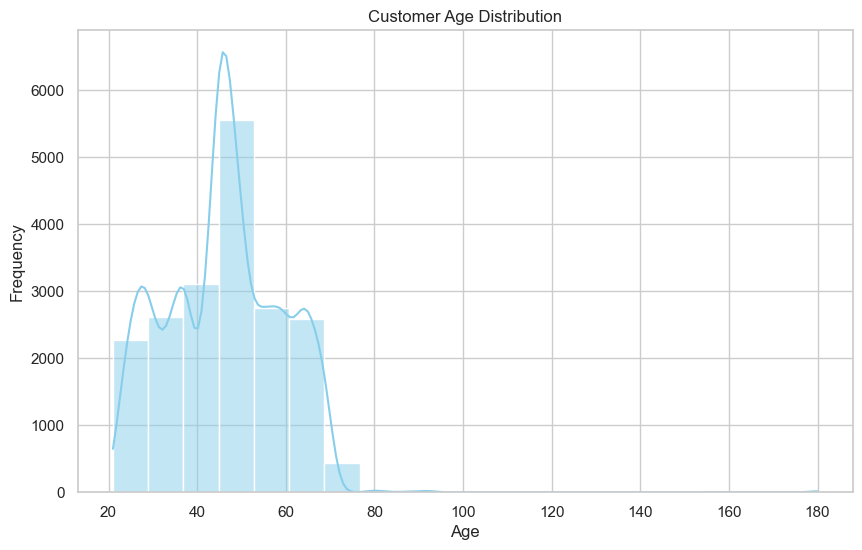

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(cust_trans_rfm['Age'], bins=20, kde=True, color='skyblue')
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

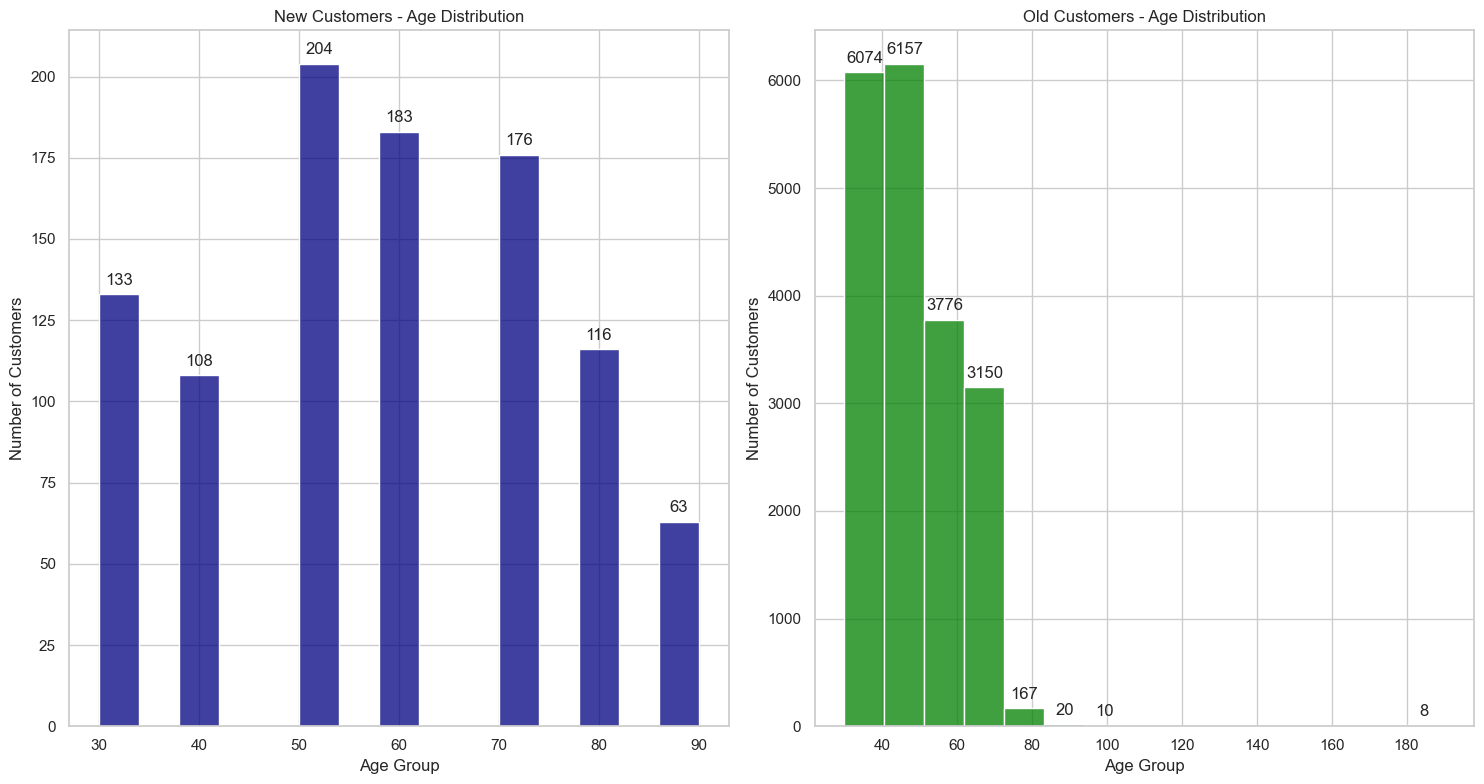

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax1 = axes[0]
sns.histplot(new_cust['Age Group'], kde=False, bins=15, color='navy', ax=ax1)
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Number of Customers')
ax1.set_title('New Customers - Age Distribution')
ax2 = axes[1]
sns.histplot(cust_trans_rfm['Age_Group'], kde=False, bins=15, color='green', ax=ax2)
for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Number of Customers')
ax2.set_title('Old Customers - Age Distribution')
plt.tight_layout()
plt.show()


In [52]:
bike_purchases_by_gender = cust_trans_rfm.groupby('gender')['past_3_years_bike_related_purchases'].sum().reset_index()
total_bike_purchases = bike_purchases_by_gender['past_3_years_bike_related_purchases'].sum()
bike_purchases_by_gender['Percent_of_total'] = (bike_purchases_by_gender['past_3_years_bike_related_purchases'] / total_bike_purchases) * 100
print("Bike Related Purchases Over Last 3 Years by Gender:")
print(bike_purchases_by_gender)

Bike Related Purchases Over Last 3 Years by Gender:
   gender  past_3_years_bike_related_purchases  Percent_of_total
0  Female                               478488         50.503731
1    Male                               468943         49.496269


In [53]:
female_purchases = bike_purchases_by_gender.loc[bike_purchases_by_gender['gender'] == 'Female', 'past_3_years_bike_related_purchases'].values[0]
male_purchases = bike_purchases_by_gender.loc[bike_purchases_by_gender['gender'] == 'Male', 'past_3_years_bike_related_purchases'].values[0]
print("Analysis:")
print(f"Over the last 3 years, approximately {female_purchases:.0f} purchases were made by female customers, "
      f"which is around {female_purchases - male_purchases:.0f} more than male customers.")

print("\nGender-wise majority of the bike sales come from female customers.")


Analysis:
Over the last 3 years, approximately 478488 purchases were made by female customers, which is around 9545 more than male customers.

Gender-wise majority of the bike sales come from female customers.


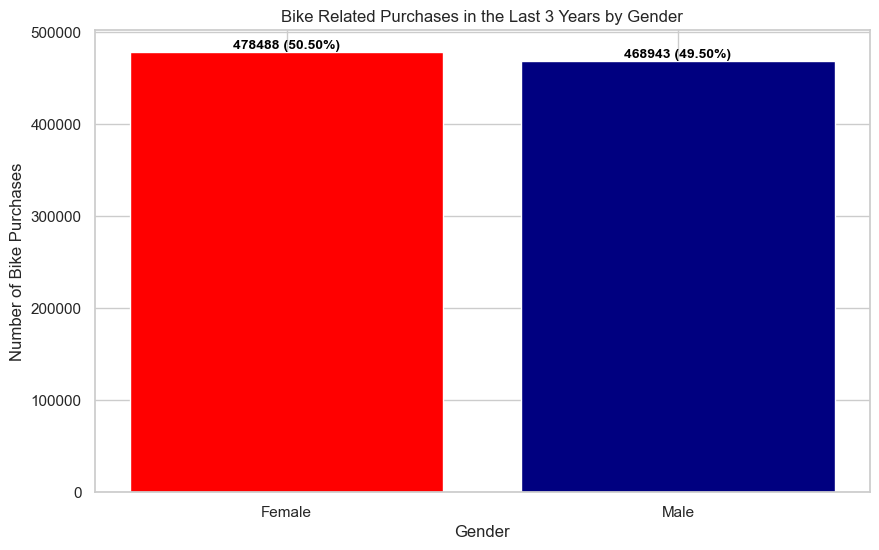

In [54]:
plt.figure(figsize=(10, 6))
total_bike_purchases = bike_purchases_by_gender['past_3_years_bike_related_purchases'].sum()
bike_purchases_by_gender['Percent_of_total'] = (bike_purchases_by_gender['past_3_years_bike_related_purchases'] / total_bike_purchases) * 100
bars = plt.bar(bike_purchases_by_gender['gender'], bike_purchases_by_gender['past_3_years_bike_related_purchases'], color=['red', 'navy'])
for bar, percentage in zip(bars, bike_purchases_by_gender['Percent_of_total']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{int(bar.get_height())} ({percentage:.2f}%)',
             ha='center', va='bottom', fontsize=10, color='black', weight='bold')
plt.xlabel('Gender')
plt.ylabel('Number of Bike Purchases')
plt.title('Bike Related Purchases in the Last 3 Years by Gender')
plt.show()

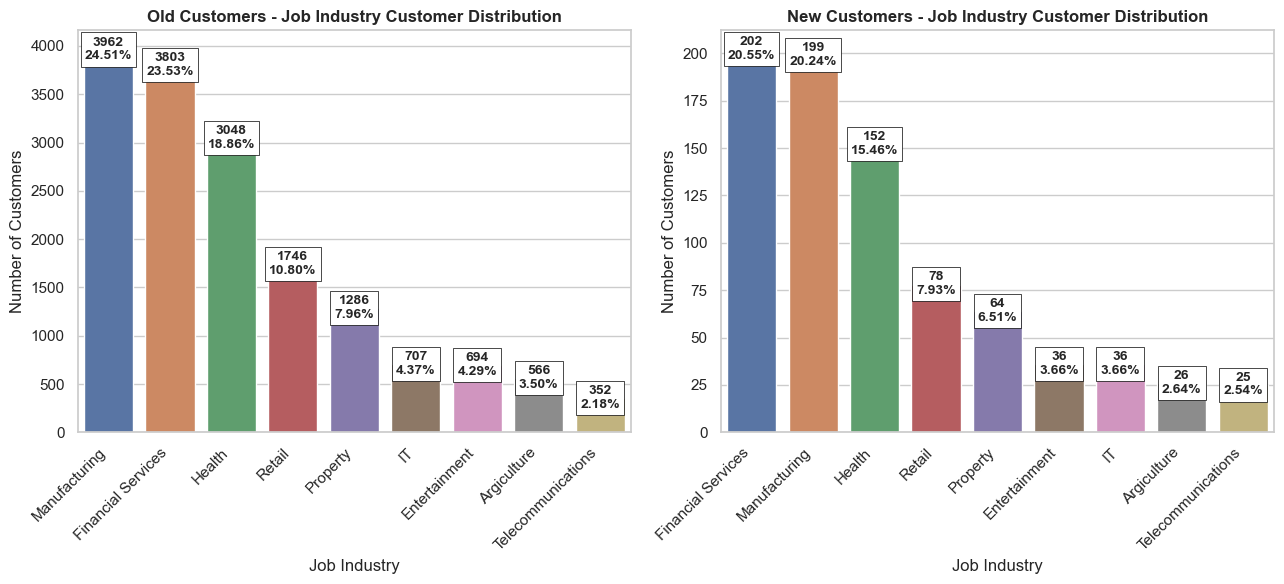

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
def add_box_around_text(ax, text, x, y):
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)
    t = ax.text(x, y, text, ha="center", va="center", bbox=bbox_props, fontsize=10, weight='bold')
ax1 = sns.countplot(x='job_industry_category', data=filtered_cust_trans_rfm, order=filtered_cust_trans_rfm['job_industry_category'].value_counts().index, ax=axes[0])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in ax1.patches:
    height = p.get_height()
    percentage_text = f'{height / len(filtered_cust_trans_rfm) * 100:.2f}%'
    number_text = f'{int(height)}'
    add_box_around_text(ax1, f'{number_text}\n{percentage_text}', p.get_x() + p.get_width() / 2., height + 0.2)
ax1.set_xlabel('Job Industry')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Old Customers - Job Industry Customer Distribution', fontweight='bold')

ax2 = sns.countplot(x='job_industry_category', data=filtered_new_cust, order=filtered_new_cust['job_industry_category'].value_counts().index, ax=axes[1])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in ax2.patches:
    height = p.get_height()
    percentage_text = f'{height / len(filtered_new_cust) * 100:.2f}%'
    number_text = f'{int(height)}'
    add_box_around_text(ax2, f'{number_text}\n{percentage_text}', p.get_x() + p.get_width() / 2., height + 0.2)
ax2.set_xlabel('Job Industry')
ax2.set_ylabel('Number of Customers')
ax2.set_title('New Customers - Job Industry Customer Distribution', fontweight='bold')
plt.tight_layout()
plt.show()

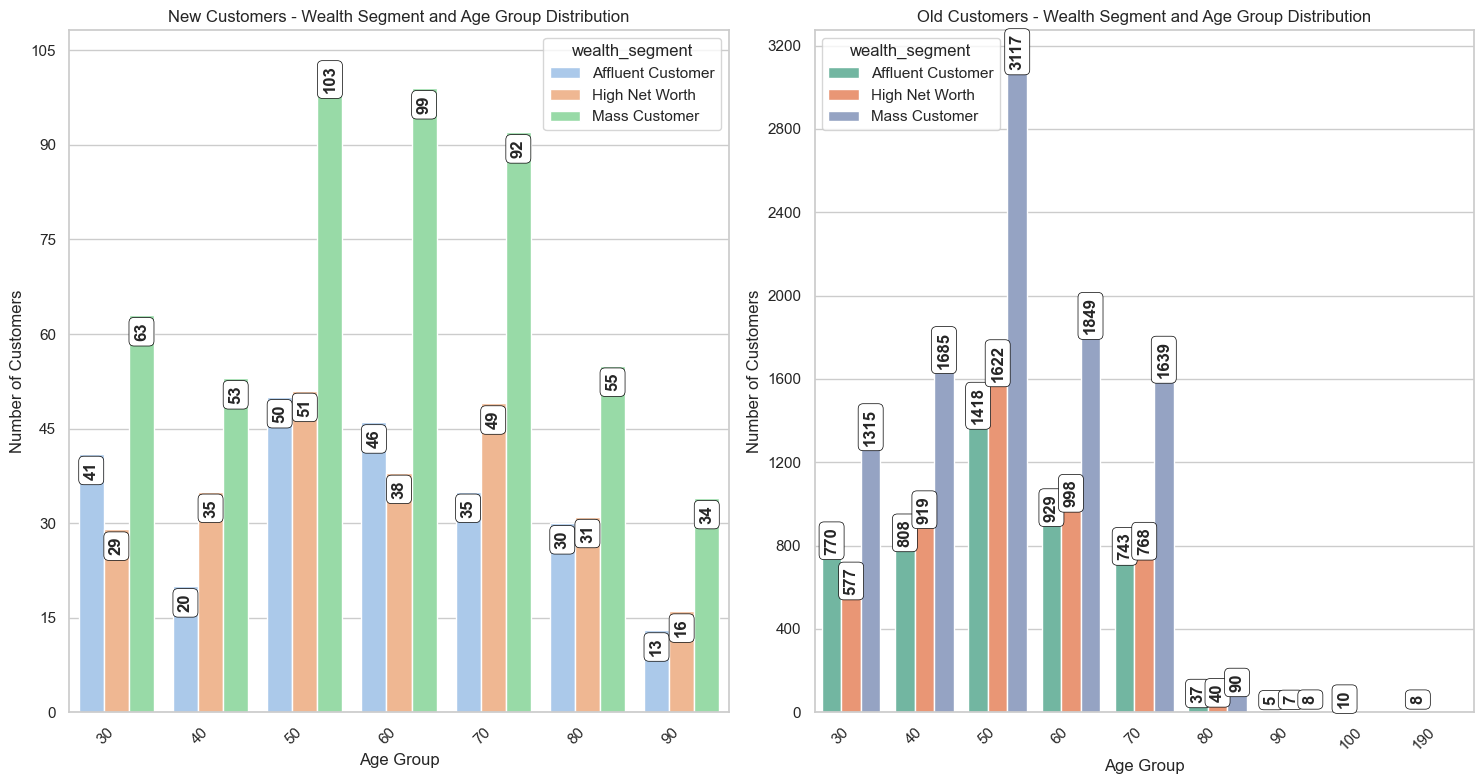

In [56]:
def annotate_bars(ax, data):
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
            text = f'{int(height)}'
            if height < 5:
                xytext = (0, 8)
            else:
                xytext = (0, -12)
            ax.annotate(text, (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center', xytext=xytext, textcoords='offset points', bbox=bbox_props, rotation='vertical', weight='bold')
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(x='Age Group', y='Number of Customers', hue='wealth_segment', data=wealth_age_seg_new, palette='pastel', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
annotate_bars(ax1, wealth_age_seg_new)
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Number of Customers')
ax1.set_title('New Customers - Wealth Segment and Age Group Distribution')
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='upper'))
ax2 = plt.subplot(1, 2, 2)
sns.barplot(x='Age_Group', y='Number of Customers', hue='wealth_segment', data=wealth_age_seg_old, palette='Set2', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
for p in ax2.patches:
    height = p.get_height()
    if not np.isnan(height):
        bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
        ax2.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', xytext=(0, 8), textcoords='offset points', bbox=bbox_props, rotation='vertical', weight='bold')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Number of Customers')
ax2.set_title('Old Customers - Wealth Segment and Age Group Distribution')
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='upper'))
plt.tight_layout()
plt.show()

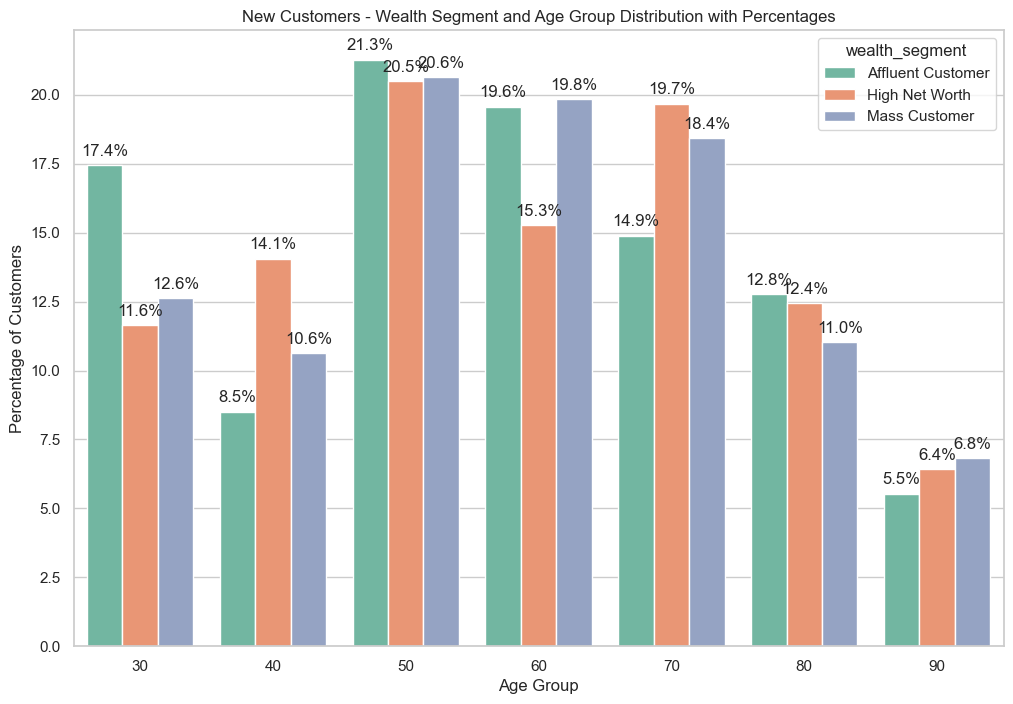

In [57]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Age Group', y='Percentage', hue='wealth_segment', data=wealth_age_seg_new, palette='Set2')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Customers')
plt.title('New Customers - Wealth Segment and Age Group Distribution with Percentages')
plt.show()

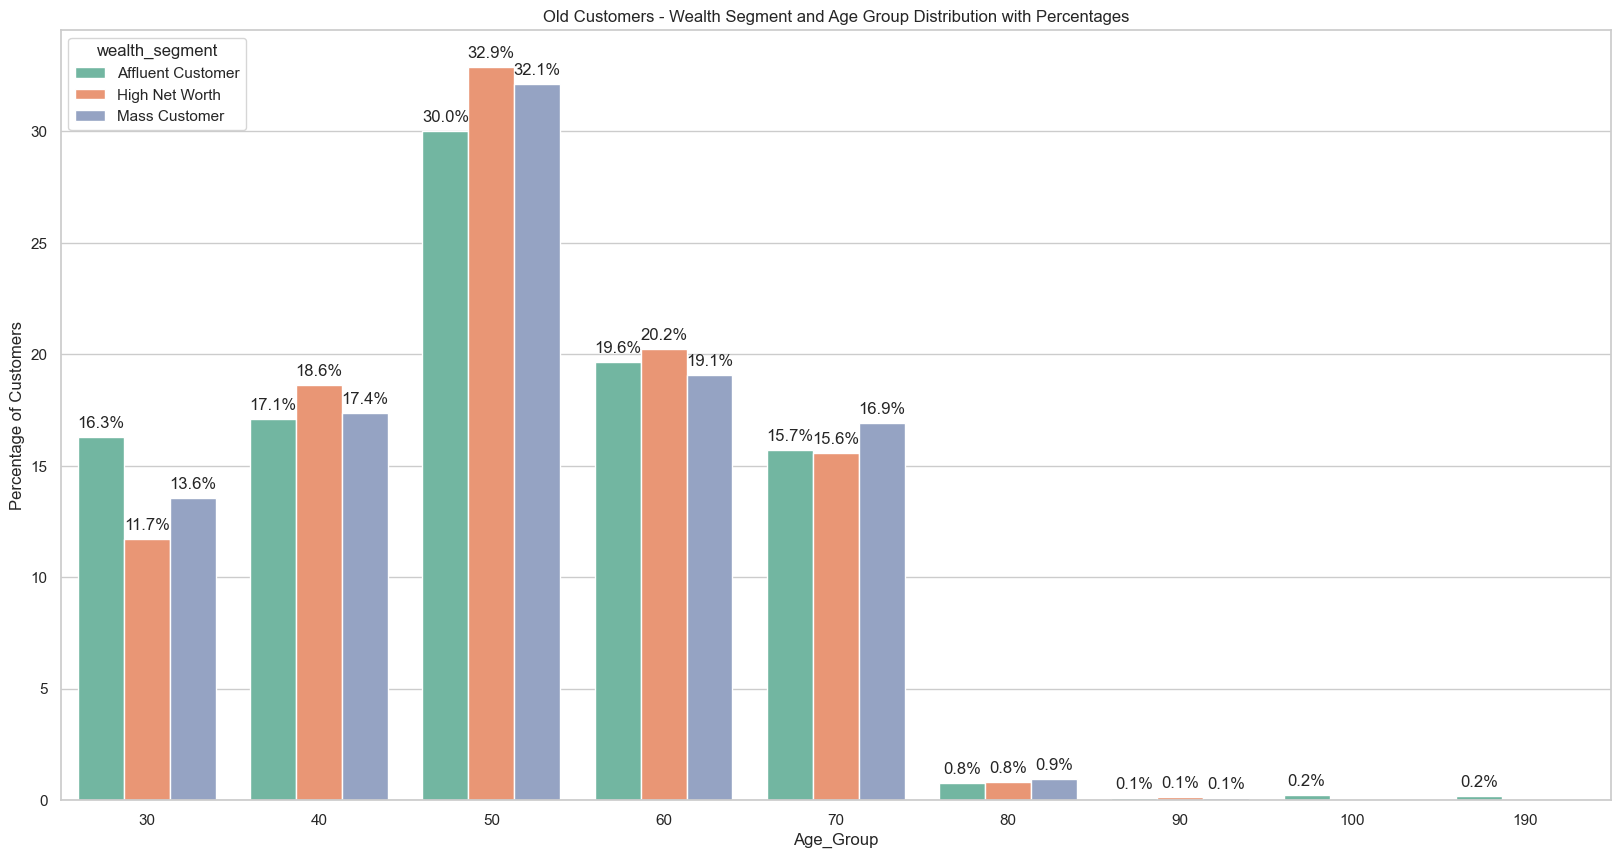

In [58]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x='Age_Group', y='old_percentage', hue='wealth_segment', data=wealth_age_seg_old, palette='Set2')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Age_Group')
plt.ylabel('Percentage of Customers')
plt.title('Old Customers - Wealth Segment and Age Group Distribution with Percentages')
plt.show()

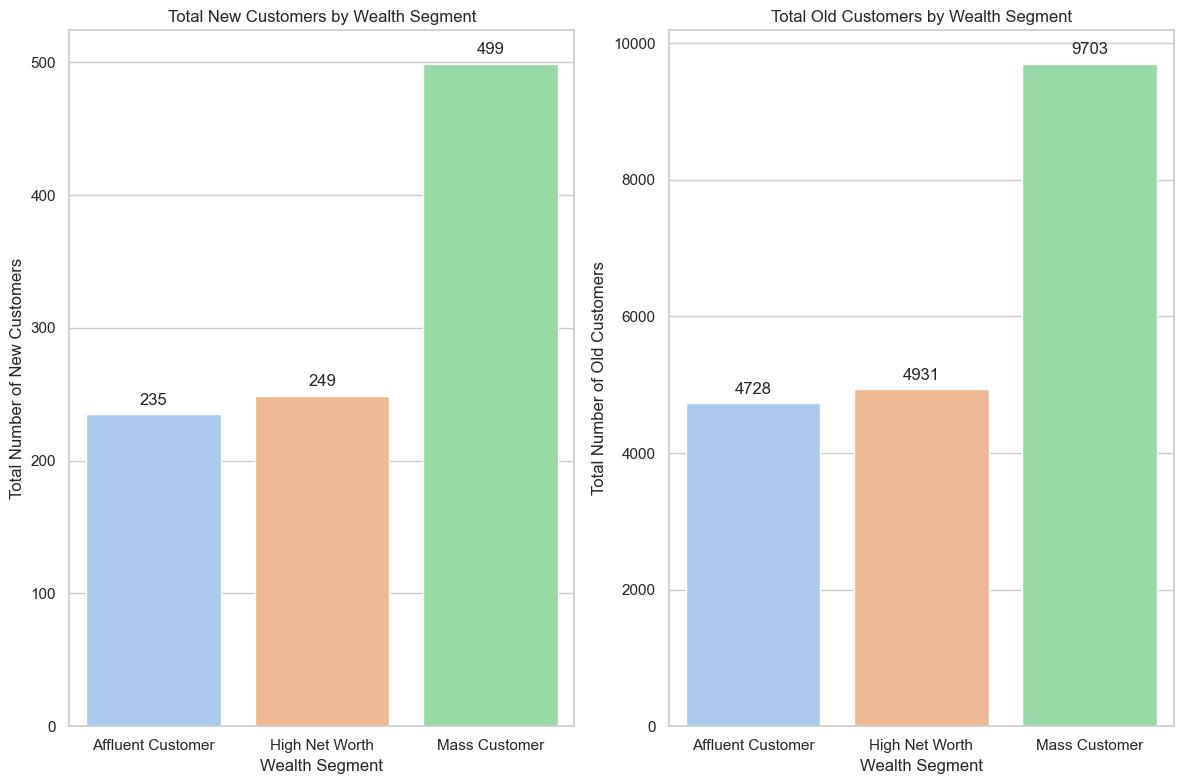

In [59]:
total_customers_by_segment = wealth_age_seg_new.groupby('wealth_segment')['Number of Customers'].sum().reset_index()
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='wealth_segment', y='Number of Customers', data=total_customers_by_segment, palette='pastel')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Wealth Segment')
plt.ylabel('Total Number of New Customers')
plt.title('Total New Customers by Wealth Segment')
total_customers_by_segment_old = wealth_age_seg_old.groupby('wealth_segment')['Number of Customers'].sum().reset_index()
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='wealth_segment', y='Number of Customers', data=total_customers_by_segment_old, palette='pastel')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Wealth Segment')
plt.ylabel('Total Number of Old Customers')
plt.title('Total Old Customers by Wealth Segment')
plt.tight_layout()
plt.show()

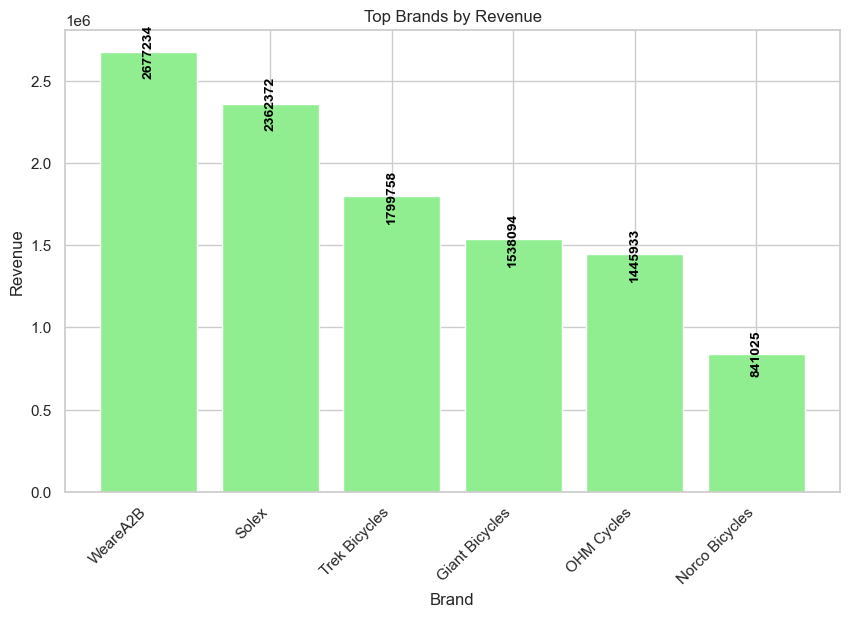

In [60]:
product_metrics = cust_trans_rfm.groupby('brand').agg(
    frequency=('product_id', 'count'),
    revenue=('Profit', 'sum'),
    average_profit=('Profit', 'mean'),
    customers=('customer_id', 'nunique')
)
product_metrics.sort_values('revenue', inplace=True, ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(product_metrics.index[:10], product_metrics['revenue'][:10], color='lightgreen')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{int(bar.get_height())}', ha='center', va='center', rotation='vertical', fontsize=10, color='black', weight='bold')
plt.xlabel('Brand')
plt.ylabel('Revenue')
plt.title('Top Brands by Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()


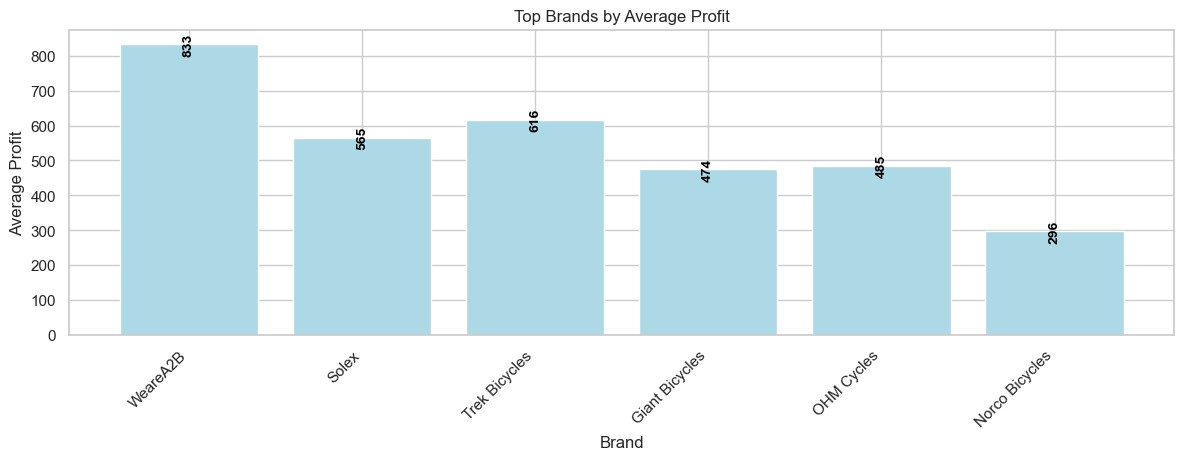

In [61]:
#product_metrics = cust_trans_rfm.groupby('brand').agg(
    #frequency=('product_id', 'count'),
    #revenue=('Profit', 'sum'),
    #average_profit=('Profit', 'mean'),
    #customers=('customer_id', 'nunique')
#)
#product_metrics.sort_values('revenue', inplace=True, ascending=False)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
bars_profit = plt.bar(product_metrics.index[:10], product_metrics['average_profit'][:10], color='lightblue')
for bar in bars_profit:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{int(bar.get_height())}', ha='center', va='center', rotation='vertical', fontsize=10, color='black', weight='bold')
plt.xlabel('Brand')
plt.ylabel('Average Profit')
plt.title('Top Brands by Average Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [62]:
product_analysis_df = perform_product_analysis(merged_dataset)

Product Analysis Summary:
              Profit   list_price
count     101.000000   101.000000
mean   105588.305446  1170.375305
std     88844.019654   543.012430
min      4782.260000   161.279184
25%     34777.040000   720.065707
50%     96997.200000  1237.634057
75%    155685.560000  1636.900000
max    587379.750000  2091.470000


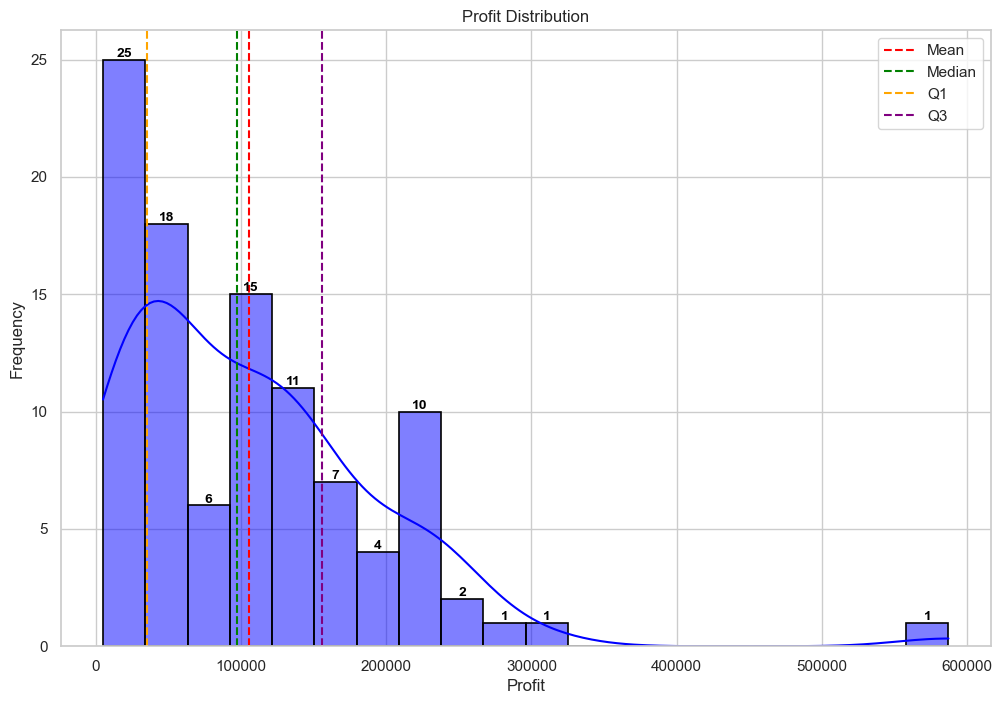

In [63]:
def visualize_profit_distribution(product_analysis_df):
    plt.figure(figsize=(12, 8))
    ax = sns.histplot(product_analysis_df['Profit'], bins=20, color='blue', kde=True, edgecolor='black', linewidth=1.2)
    plt.axvline(x=product_analysis_df['Profit'].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(x=product_analysis_df['Profit'].median(), color='green', linestyle='--', label='Median')
    plt.axvline(x=product_analysis_df['Profit'].quantile(0.25), color='orange', linestyle='--', label='Q1')
    plt.axvline(x=product_analysis_df['Profit'].quantile(0.75), color='purple', linestyle='--', label='Q3')
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black', weight='bold')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
    plt.legend()
    plt.title('Profit Distribution')
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    plt.show()
visualize_profit_distribution(product_analysis_df)

In [64]:
state_car_owners = (
    cust_trans_addr[['state', 'owns_car', 'customer_id']]
    .drop_duplicates()
    .groupby(['state', 'owns_car'])
    .size()
    .reset_index(name='Number of Customers')
)
state_car_owners.rename(columns={'state': 'State', 'owns_car': 'Owns Car'}, inplace=True)
state_car_owners

State Owns Car  Number of Customers
0   NSW       No                  889
1   NSW      Yes                  935
2   QLD       No                  366
3   QLD      Yes                  363
4   VIC       No                  435
5   VIC      Yes                  425

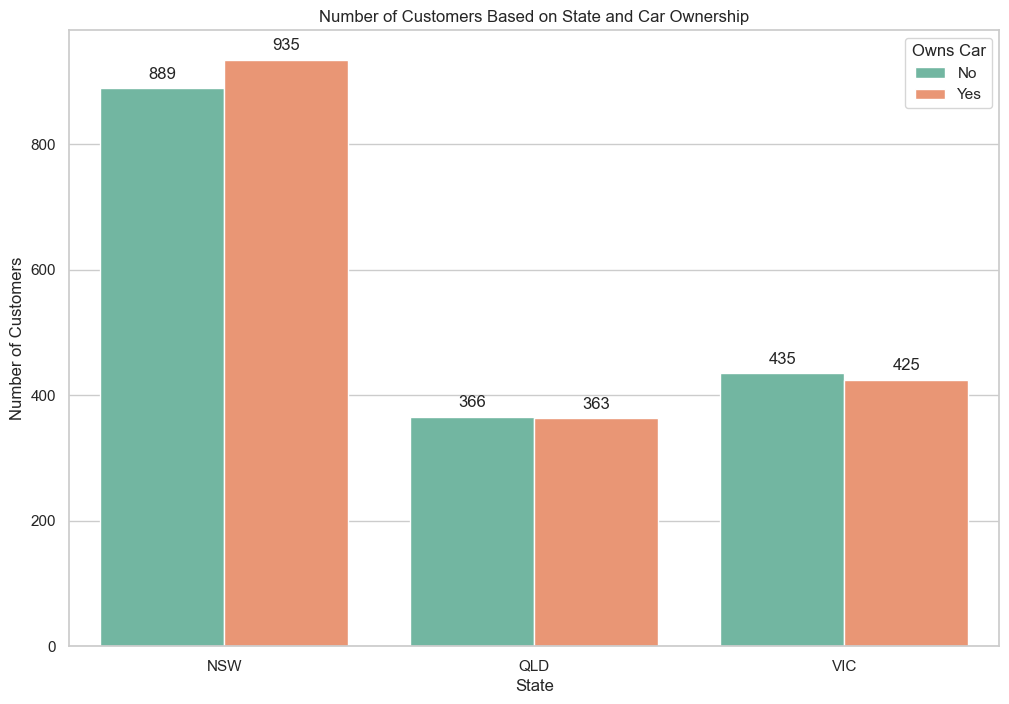

In [65]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='State', y='Number of Customers', hue='Owns Car', data=state_car_owners, palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Based on State and Car Ownership')
plt.show()


In [66]:
def create_time_based_trends(merged_dataset):
    merged_dataset['transaction_date'] = pd.to_datetime(merged_dataset['transaction_date'])
    merged_dataset['month'] = merged_dataset['transaction_date'].dt.to_period('M')
    merged_dataset['quarter'] = merged_dataset['transaction_date'].dt.to_period('Q')
    monthly_trends = merged_dataset.groupby('month').agg({
        'Profit': 'sum',
        'customer_id': 'nunique'
    }).reset_index()
    quarterly_trends = merged_dataset.groupby('quarter').agg({
        'Profit': 'sum',
    }).reset_index()
    return monthly_trends, quarterly_trends

In [67]:
def visualize_time_based_trends(monthly_trends, quarterly_trends):
    monthly_trends['month'] = monthly_trends['month'].astype(str)
    quarterly_trends['quarter'] = quarterly_trends['quarter'].astype(str)
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_trends['month'], monthly_trends['Profit'], label='Monthly Revenue', marker='o')
    plt.title('Monthly Trends')
    plt.xlabel('Month')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(quarterly_trends['quarter'], quarterly_trends['Profit'], label='Quarterly Revenue', marker='o')
    plt.title('Quarterly Trends')
    plt.xlabel('Quarter')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

In [68]:
monthly_trends, quarterly_trends = create_time_based_trends(merged_dataset)

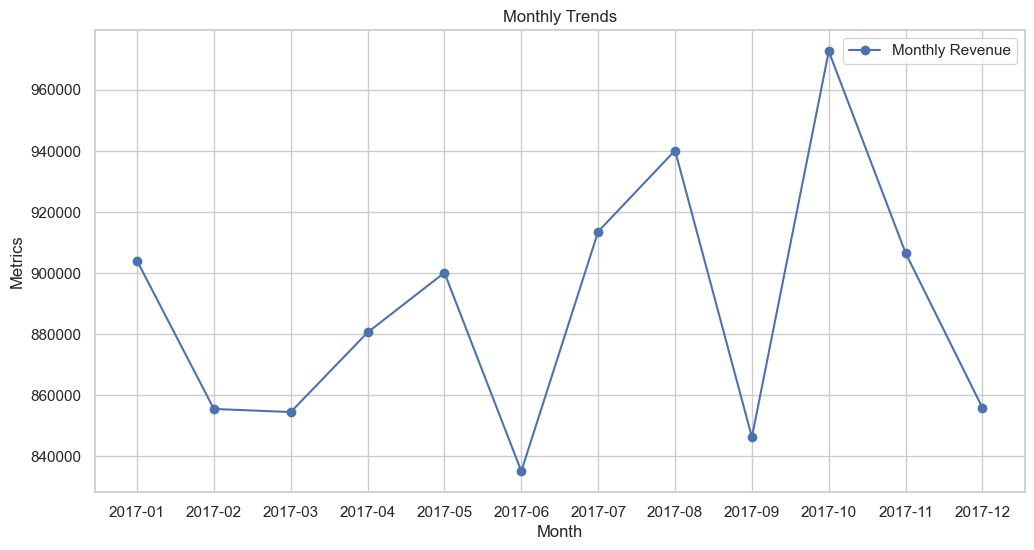

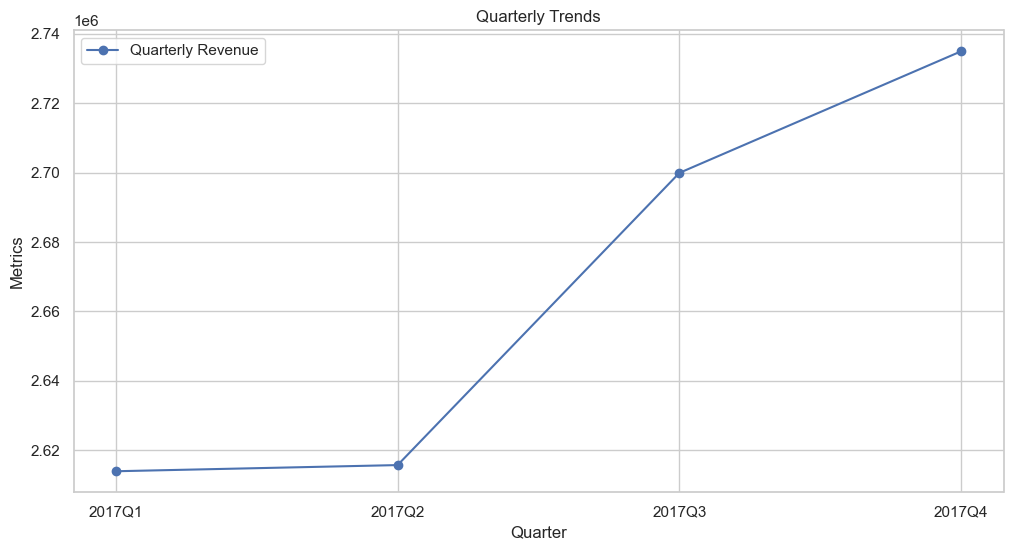

In [69]:
visualize_time_based_trends(monthly_trends, quarterly_trends)

In [70]:
def chi_squared_test(cust_trans_rfm, variable):
    contingency_table = pd.crosstab(cust_trans_rfm[variable], cust_trans_rfm['detail_cust_title'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-squared test result for {variable} and Customer Title:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")

def visualize_demographic_distribution(cust_trans_rfm, variable):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=variable, hue='detail_cust_title', data=cust_trans_rfm, palette='viridis')
    plt.title(f'Distribution of Customers by {variable}')
    plt.xlabel(variable)
    plt.ylabel('Number of Customers')
    plt.legend(title='Customer Title')
    plt.show()

def create_tenure_group_feature(cust_trans_rfm):
    cust_trans_rfm['tenure_group'] = pd.qcut(cust_trans_rfm['tenure'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

In [71]:
chi_squared_test(cust_trans_rfm, 'gender')

Chi-squared test result for gender and Customer Title:
Chi2 Statistic: 50.02793702780386
P-value: 2.6376934157313847e-07


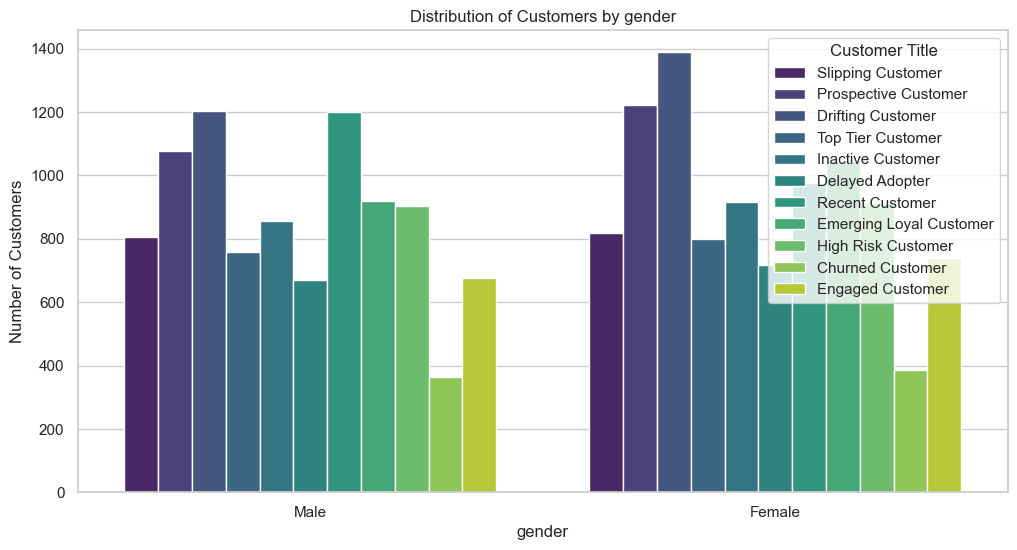

In [72]:
visualize_demographic_distribution(cust_trans_rfm, 'gender')

In [73]:
chi_squared_test(cust_trans_rfm, 'wealth_segment')

Chi-squared test result for wealth_segment and Customer Title:
Chi2 Statistic: 141.4576193008024
P-value: 2.6766532982496222e-20


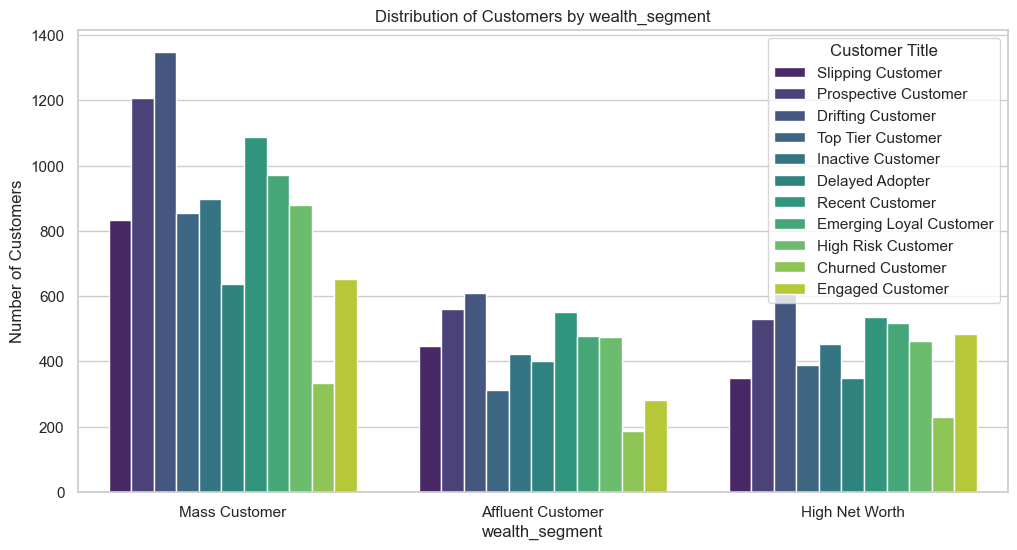

In [74]:
visualize_demographic_distribution(cust_trans_rfm, 'wealth_segment')

In [75]:
chi_squared_test(cust_trans_rfm, 'owns_car')

Chi-squared test result for owns_car and Customer Title:
Chi2 Statistic: 85.06157481562643
P-value: 5.0758010498869466e-14


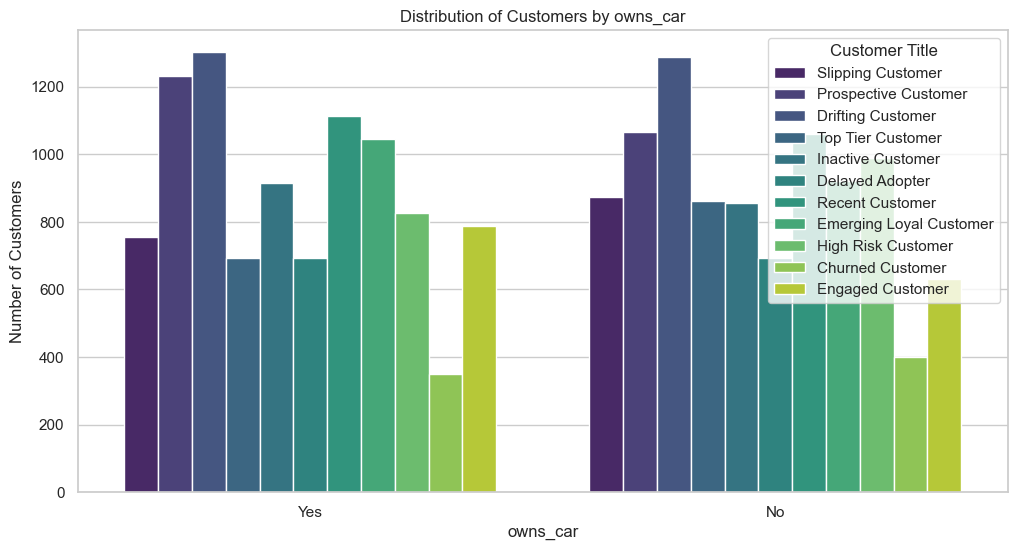

In [76]:
visualize_demographic_distribution(cust_trans_rfm, 'owns_car')

In [77]:
create_tenure_group_feature(cust_trans_rfm)

In [78]:
chi_squared_test(cust_trans_rfm, 'tenure_group')

Chi-squared test result for tenure_group and Customer Title:
Chi2 Statistic: 209.67221606627731
P-value: 7.25473894602142e-25


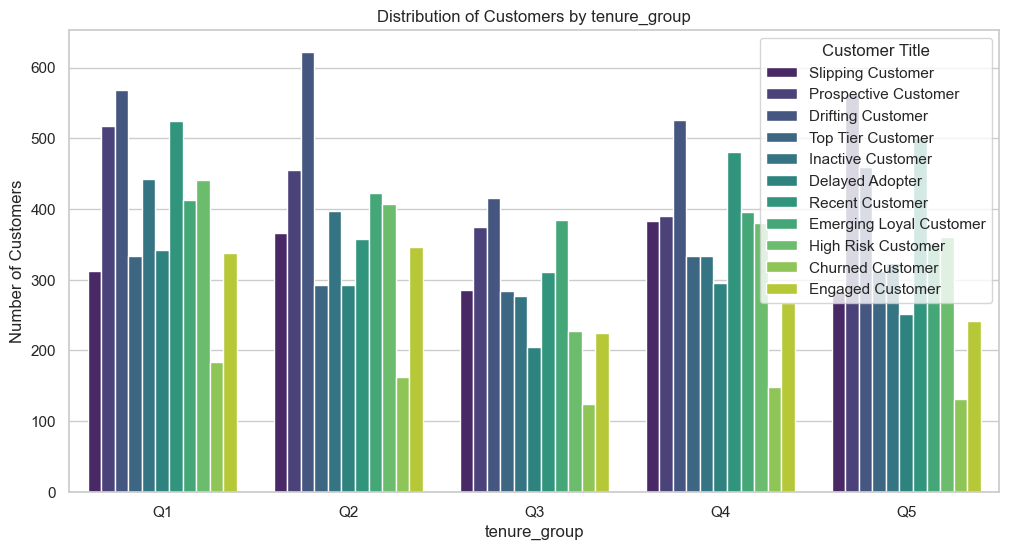

In [79]:
visualize_demographic_distribution(cust_trans_rfm, 'tenure_group')